In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [7]:
!unzip /content/caltech-transportation\ \(2\).zip

Archive:  /content/caltech-transportation (2).zip
   creating: caltech-transportation_test/
   creating: caltech-transportation_test/airplanes/
  inflating: caltech-transportation_test/airplanes/image_0003.jpg  
  inflating: caltech-transportation_test/airplanes/image_0008.jpg  
  inflating: caltech-transportation_test/airplanes/image_0011.jpg  
  inflating: caltech-transportation_test/airplanes/image_0024.jpg  
  inflating: caltech-transportation_test/airplanes/image_0030.jpg  
  inflating: caltech-transportation_test/airplanes/image_0031.jpg  
  inflating: caltech-transportation_test/airplanes/image_0032.jpg  
  inflating: caltech-transportation_test/airplanes/image_0034.jpg  
  inflating: caltech-transportation_test/airplanes/image_0040.jpg  
  inflating: caltech-transportation_test/airplanes/image_0050.jpg  
  inflating: caltech-transportation_test/airplanes/image_0055.jpg  
  inflating: caltech-transportation_test/airplanes/image_0064.jpg  
  inflating: caltech-transportation_test

In [13]:
TRAIN_DIR = "/content/caltech-transportation_test"
TEST_DIR  = "/content/caltech-transportation_train"


In [14]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 25
N_RUNS = 3   # ή 5 αν αντέχει το Colab


In [15]:
def create_generators(img_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_gen = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, test_gen


In [16]:
def build_scratch_cnn(input_shape, num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3,3), activation='relu',
                     padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Block 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Block 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Classifier
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [17]:
results = []

for run in range(N_RUNS):
    print(f"\n==============================")
    print(f"🔁 RUN {run+1}/{N_RUNS}")
    print(f"==============================")

    # για αναπαραγωγιμότητα (μέχρι ενός σημείου)
    tf.keras.backend.clear_session()
    tf.random.set_seed(run)
    np.random.seed(run)

    # generators
    train_gen, test_gen = create_generators(IMG_SIZE, BATCH_SIZE)

    # μοντέλο
    model = build_scratch_cnn(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        num_classes=train_gen.num_classes
    )

    # callbacks
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint(
        f"cnn_scratch_gtsrb_run{run+1}.h5",
        save_best_only=True
    )

    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=EPOCHS,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    # αξιολόγηση στο test set
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"✅ Run {run+1} – Test Accuracy: {test_acc:.4f}")

    results.append({
        "Run": run + 1,
        "Test Accuracy": float(test_acc)
    })



🔁 RUN 1/3
Found 366 images belonging to 5 classes.
Found 1453 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.5257 - loss: 3.8167

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5447 - loss: 3.7376 - val_accuracy: 0.4460 - val_loss: 2.2164
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7930 - loss: 1.3672

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7945 - loss: 1.3613 - val_accuracy: 0.5871 - val_loss: 1.3195
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.8065 - loss: 1.1362

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8119 - loss: 1.1113 - val_accuracy: 0.6614 - val_loss: 0.9473
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.7951 - loss: 0.8920

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7998 - loss: 0.8677 - val_accuracy: 0.5891 - val_loss: 0.9315
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9047 - loss: 0.3440 - val_accuracy: 0.4432 - val_loss: 1.4431
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9107 - loss: 0.2824 - val_accuracy: 0.4625 - val_loss: 2.8589
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9307 - loss: 0.1951 - val_accuracy: 0.4549 - val_loss: 6.0102
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9196 - loss: 0.2369 - val_accuracy: 0.4577 - val_loss: 6.8700
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9163 - loss: 0.4039 - val_accuracy: 0.4460 - val_loss: 7.9553
✅ Run 1 – Test Accuracy: 0.5891

🔁 RUN 2/3
Found 366 images belonging to 5 classes.
Found 1453 images belonging to 5 classes.
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.4600 - loss: 4.3512

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4817 - loss: 4.3289 - val_accuracy: 0.4391 - val_loss: 1.6212
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.8384 - loss: 1.9226

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8393 - loss: 1.8660 - val_accuracy: 0.5382 - val_loss: 1.0193
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8589 - loss: 0.7666 - val_accuracy: 0.3957 - val_loss: 2.0151
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8921 - loss: 0.5743 - val_accuracy: 0.0509 - val_loss: 5.5358
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9301 - loss: 0.3078 - val_accuracy: 0.0365 - val_loss: 10.8214
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9304 - loss: 0.2683 - val_accuracy: 0.0365 - val_loss: 14.9994
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9261 - loss: 0.4216 - val_accuracy: 0.0365 - val_loss: 18.2198
✅ Run 2 – Test Accuracy: 0.5382

🔁 RUN 3/3
Found 366 images belonging to 5 classes.
Found 1453 images belonging to 5 classes.
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.5232 - loss: 3.7314

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5437 - loss: 3.7532 - val_accuracy: 0.4384 - val_loss: 2.7211
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.7966 - loss: 1.7104

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7991 - loss: 1.6792 - val_accuracy: 0.5816 - val_loss: 1.3438
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8303 - loss: 0.7884 - val_accuracy: 0.5348 - val_loss: 1.4095
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.8633 - loss: 0.5373

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8660 - loss: 0.5276 - val_accuracy: 0.6111 - val_loss: 1.0364
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.9032 - loss: 0.3928

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9033 - loss: 0.3894 - val_accuracy: 0.7894 - val_loss: 0.7329
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9064 - loss: 0.2872 - val_accuracy: 0.7598 - val_loss: 1.1688
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9483 - loss: 0.1772 - val_accuracy: 0.6001 - val_loss: 2.4447
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9326 - loss: 0.2881 - val_accuracy: 0.4646 - val_loss: 4.3296
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9435 - loss: 0.1772 - val_accuracy: 0.4460 - val_loss: 7.8556
Epoch 10/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9458 - loss: 0.2250 - val_accuracy: 0.4460 - val_loss: 8.9474
✅ Run 3 – Test Accuracy: 0.7894


In [18]:
df_results = pd.DataFrame(results)
mean_acc = df_results["Test Accuracy"].mean()
std_acc = df_results["Test Accuracy"].std()

print("\n==============================")
print("📊 ΑΠΟΤΕΛΕΣΜΑΤΑ CNN από το μηδέν (GTSRB)")
print(df_results)
print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Std: {std_acc:.4f}")
print("==============================")



📊 ΑΠΟΤΕΛΕΣΜΑΤΑ CNN από το μηδέν (GTSRB)
   Run  Test Accuracy
0    1       0.589126
1    2       0.538197
2    3       0.789401

Mean Accuracy: 0.6389
Std: 0.1328


In [19]:
df_results.to_csv("cnn_1_scratch_GTSRB_results.csv", index=False)


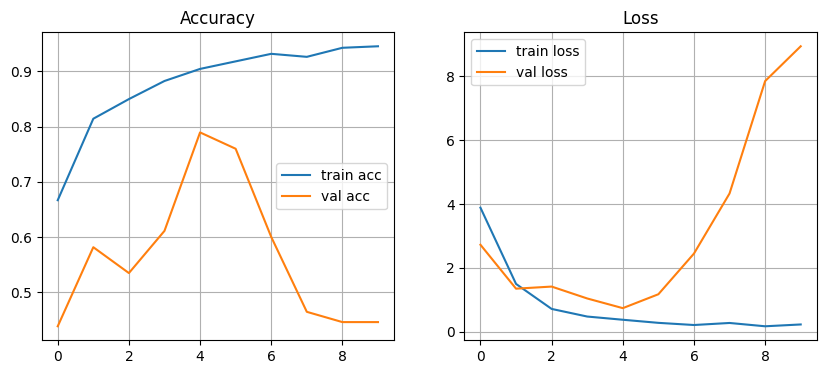

In [20]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.grid()

plt.show()
